**Arjun Krishnan - 6622982 - Natural Language Processing, Individual component - Notebook 1**

The 'Questions from cross validated stack exchange' dataset contains 85,085 questions related to various topics like statistics, machine learning, etc. The questions are categorized based on the topic called as tags.

**Aim:**

The aim of the individual commitment part of the project is to build  multi-label classifier CNN model to predict tags for a given Stack Exchange question by using the title and body of the questions. 

**Dataset** : Questions from cross  validated stack exchange,
***source***: https://www.kaggle.com/stackoverflow/statsquestions 

**Why CNN?**

Deep Convolutional Neural Networks has been widely used for Computer Vision and Image classification tasks, However in the recent years CNN's are gaining poularity for Natural Language processing as well. Convolutional Networks are faster when compared to other algorithms as they are a central part of computer graphics and implemented on a hardware level in GPU's and are also efficient in terms of representation. Although CNN's may not be as powerful as other algorithms for NLP like LSTM or RNN, In some cases CNN's have performed exceptionally well. 

We aim to address the problem at hand by experimenting with various setups/methodologies such as Random embeddings, Wor2Vec Embeddings of various dimensions with 1D, 2D CNN's along with different hyperparameters. 

**Tasks carried out in this notebook**
1. Basic analysis and visualisaion of the data
2. Data preparation
3. Text pre processing
4. Model building
5. Train and compare models 1 and 2. 
6. Further steps


In [3]:
#checking if we are using GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
#checking if the available ram is used
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


Installing and importing the required libraries.

In [5]:
!pip install unidecode
!pip install contractions
!pip install tensorflow-addons
!pip install wordcloud

from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib as plt
import re
import contractions
import nltk
import sklearn
import tensorflow_addons as tfa
import gensim
import matplotlib.pyplot as plt
import os

from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from unidecode import unidecode
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words
from nltk.tokenize import regexp_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer

nltk.download('stopwords')

     |████████████████████████████████| 245kB 7.2MB/s 
     |████████████████████████████████| 286kB 9.1MB/s 
     |████████████████████████████████| 327kB 17.3MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85398 sha256=3ed408a867c285e12656833d9e97aaae27f072a525059bd387a179bef864dd89
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick
     |████████████████████████████████| 706kB 8.9MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


True

In [6]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#choosing working directory
import os
os.chdir("./drive/MyDrive/NLPCW/")

In [8]:
#listing items in the directory
os.listdir()

['Questions.csv',
 'Tags.csv',
 'GoogleNews-vectors-negative300.txt',
 'exp2_data.csv',
 'model2-EXP3.h5',
 'model2-EXP2.h5',
 'preprocdata.csv',
 'preprocstats.csv',
 'model1-NLPCW.h5',
 'model2-NLPCW.h5',
 'model3-NLPCW.h5',
 'model4-NLPCW.h5',
 'model5-NLPCW.h5',
 'model6-NLPCW.h5',
 'corpus_word2vec.txt']

In [9]:
#Reading the tags and question data
questions = pd.read_csv('Questions.csv', encoding='latin-1')
tags = pd.read_csv('Tags.csv', encoding='iso-8859-1')

In [10]:
questions.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,6,5.0,2010-07-19T19:14:44Z,272,The Two Cultures: statistics vs. machine learn...,"<p>Last year, I read a blog post from <a href=..."
1,21,59.0,2010-07-19T19:24:36Z,4,Forecasting demographic census,<p>What are some of the ways to forecast demog...
2,22,66.0,2010-07-19T19:25:39Z,208,Bayesian and frequentist reasoning in plain En...,<p>How would you describe in plain English the...
3,31,13.0,2010-07-19T19:28:44Z,138,What is the meaning of p values and t values i...,<p>After taking a statistics course and then t...
4,36,8.0,2010-07-19T19:31:47Z,58,Examples for teaching: Correlation does not me...,"<p>There is an old saying: ""Correlation does n..."


In [11]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85085 entries, 0 to 85084
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            85085 non-null  int64  
 1   OwnerUserId   84101 non-null  float64
 2   CreationDate  85085 non-null  object 
 3   Score         85085 non-null  int64  
 4   Title         85085 non-null  object 
 5   Body          85085 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 3.9+ MB


In [12]:
tags.head()

,Id,Tag
0,1,bayesian
1,1,prior
2,1,elicitation
3,2,distributions
4,2,normality


In [13]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244228 entries, 0 to 244227
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Id      244228 non-null  int64 
 1   Tag     244228 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


In [14]:
#Number of unique tags in the data
len(tags['Tag'].unique())

1315

In [15]:
#Removing '-' from tags
tags['Tag'] = tags['Tag'].apply(lambda x:re.sub("-"," ",x))
tags.head()

,Id,Tag
0,1,bayesian
1,1,prior
2,1,elicitation
3,2,distributions
4,2,normality


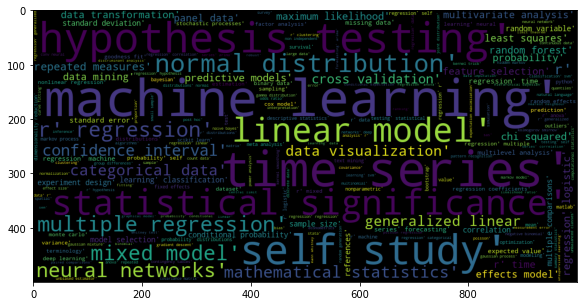

In [16]:
#visualizing the tags present in the data as a wordcloud
tuplelist = []
for text in tags.values:
  tuplelist.append(tuple(text))
wordcloud = WordCloud(width=1000, height = 500).generate(str(tuplelist))
fig = plt.figure(figsize = (10,5))
plt.imshow(wordcloud)
plt.show()

The data-set contains a total of 1315 unique tags, a lot of tags have a very small distribution in data. Therefore after experimenting and discussing with group mates, we decided to use only 20 most occuring tags as it would provide us with enough data to train and test the model. 

In [17]:
#Grouping tags together
grouped_tags = tags.groupby("Tag", sort='count').size().reset_index(name='count')

#choosing only the top 20 tags
top20tags = 20
grouped_tags = tags.groupby('Tag').size().reset_index(name='count')
common_tags = grouped_tags.nlargest(top20tags, columns="count")
tags.Tag = tags.Tag.apply(lambda x:x if x in common_tags.Tag.values else None)
tags = tags.dropna()

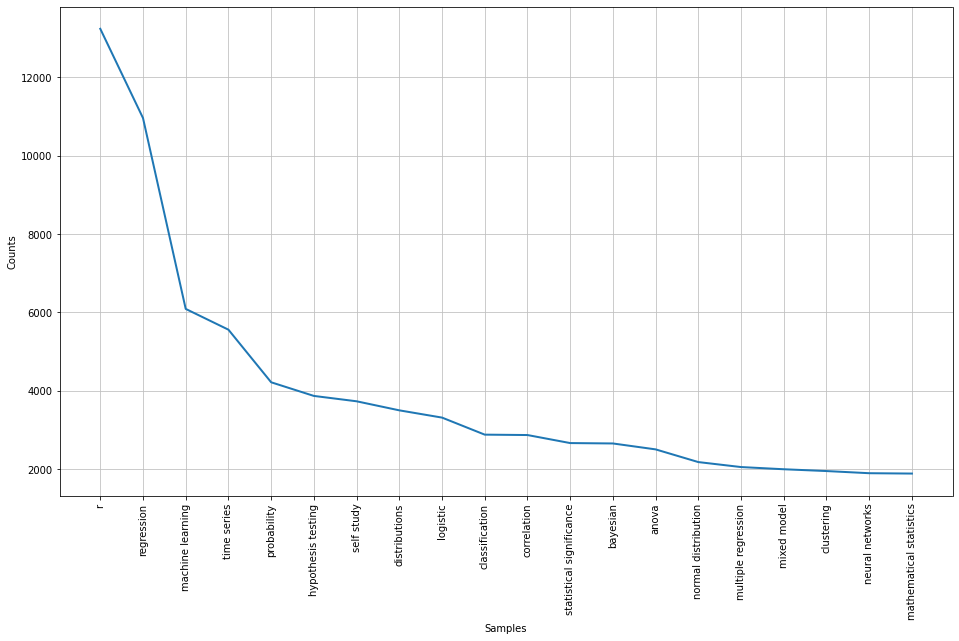

In [18]:
#Visualizing the top 20 tags
keywords = nltk.FreqDist(tags['Tag'])
keywords = nltk.FreqDist(keywords)
plt.rcParams["figure.figsize"] = [16,9]
keywords.plot(50, cumulative=False)

# Data preparation 
1. As some HTML tags are present, we remove them before moving forward.
2. The Questions(features) are split into 'title' and 'body' in our data, therefore they are merged together. 
3. 'Tags' (Labels) and 'Questions' (Features) data are merged together based on the ID.
4. Labels are converted to multilabel format using MultiLabelBinarizer()
5. Dropping some of the columns, only the required columns are retained.
6. Removing rows without labels.

In [19]:
#stripping html tags
def strip_html_tags(body):
    regex = re.compile('<.*?>')
    return re.sub(regex, '', body)

questions['Body'] = questions['Body'].apply(strip_html_tags)

In [20]:
#combining the title and body of the question into one field 
questions['Text'] = questions['Title'] + ' ' + questions['Body']

In [21]:
# combining the tags and questions data
def tags_for_question(question_id):
    return tags[tags['Id'] == question_id].Tag.values

def add_tags_column(row):
    row['Tags'] = tags_for_question(row['Id'])
    return row

questions = questions.apply(add_tags_column, axis=1)

In [22]:
questions.shape

(85085, 8)

In [23]:
pd.set_option('display.max_colwidth', 400)
df = questions[['Id', 'Text', 'Tags']]

In [24]:
df.head()

,Id,Text,Tags
0,6,"The Two Cultures: statistics vs. machine learning? Last year, I read a blog post from Brendan O'Connor entitled ""Statistics vs. Machine Learning, fight!"" that discussed some of the differences between the two fields. Andrew Gelman responded favorably to this:\n\nSimon Blomberg: \n\n\n From R's fortunes\n package: To paraphrase provocatively,\n 'machine learning is statistics minus\n any c...",[machine learning]
1,21,"Forecasting demographic census What are some of the ways to forecast demographic census with some validation and calibration techniques?\n\nSome of the concerns:\n\n\nCensus blocks vary in sizes as rural\nareas are a lot larger than condensed\nurban areas. Is there a need to account for the area size difference?\nif let's say I have census data\ndating back to 4 - 5 census periods,\nhow far ca...",[]
2,22,Bayesian and frequentist reasoning in plain English How would you describe in plain English the characteristics that distinguish Bayesian from Frequentist reasoning?\n,[bayesian]
3,31,"What is the meaning of p values and t values in statistical tests? After taking a statistics course and then trying to help fellow students, I noticed one subject that inspires much head-desk banging is interpreting the results of statistical hypothesis tests. It seems that students easily learn how to perform the calculations required by a given test but get hung up on interpreting the resul...",[hypothesis testing]
4,36,"Examples for teaching: Correlation does not mean causation There is an old saying: ""Correlation does not mean causation"". When I teach, I tend to use the following standard examples to illustrate this point:\n\n\nnumber of storks and birth rate in Denmark;\nnumber of priests in America and alcoholism;\nin the start of the 20th century it was noted that there was a strong correlation between 'N...",[correlation]


A list of sets or tuples is a very easy to undertand for multilabel data, it is difficult to process due to the shape and complexity of multilable data. The Multilable binarizer converts  this easy to understand format to a supported multilabel format: a binary matrix of sample and classes. indicates the presence of a class label if its 1 or 0 in the case of absence of a label.

*source:* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html

In [25]:
#converts to the  multilabel format: a (samples x classes) binary matrix indicating the presence of a class label
mlb = MultiLabelBinarizer()
labels = pd.DataFrame(mlb.fit_transform(questions.Tags.values),columns=mlb.classes_)

In [26]:
#combining the questions with the labels after using MultiLabelBinarizer()
df_combined = pd.concat([questions,labels], axis=1)
df_combined.shape

(85085, 28)

In [27]:
#dropping columns that are not required for the task at hand
df_combined = df_combined.drop(columns = ['Id', 'OwnerUserId', 'CreationDate', 'Score', 'Title', 'Body', 'Tags'], axis=1)

In [28]:
#Removing rows without labels, as data without the labels is not useful for us.
#code referenced from Teammate Tsang Fan yum
df = df_combined[df_combined[df_combined.columns[1:]].sum(axis=1) != 0]

In [29]:
#resetting the index after dropping rows
df = df.reset_index(drop=True)

In [30]:
df.head(5)

,Text,anova,bayesian,classification,clustering,correlation,distributions,hypothesis testing,logistic,machine learning,mathematical statistics,mixed model,multiple regression,neural networks,normal distribution,probability,r,regression,self study,statistical significance,time series
0,"The Two Cultures: statistics vs. machine learning? Last year, I read a blog post from Brendan O'Connor entitled ""Statistics vs. Machine Learning, fight!"" that discussed some of the differences between the two fields. Andrew Gelman responded favorably to this:\n\nSimon Blomberg: \n\n\n From R's fortunes\n package: To paraphrase provocatively,\n 'machine learning is statistics minus\n any c...",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Bayesian and frequentist reasoning in plain English How would you describe in plain English the characteristics that distinguish Bayesian from Frequentist reasoning?\n,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"What is the meaning of p values and t values in statistical tests? After taking a statistics course and then trying to help fellow students, I noticed one subject that inspires much head-desk banging is interpreting the results of statistical hypothesis tests. It seems that students easily learn how to perform the calculations required by a given test but get hung up on interpreting the resul...",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Examples for teaching: Correlation does not mean causation There is an old saying: ""Correlation does not mean causation"". When I teach, I tend to use the following standard examples to illustrate this point:\n\n\nnumber of storks and birth rate in Denmark;\nnumber of priests in America and alcoholism;\nin the start of the 20th century it was noted that there was a strong correlation between 'N...",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,How Large a Difference Can Be Expected Between Standard GARCH and Asymmetric GARCH Volatility Forecasts? I have been using various GARCH-based models to forecast volatility for various North American equities using historical daily data as inputs.\n\nAsymmetric GARCH models are often cited as a modification of the basic GARCH model to account for the 'leverage effect' i.e. volatility tends to ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# **Text Preprocessing**
It is important to remove redundant characters from our text corpus as they do have any significant impact towards the output we expect. As things such as punctuations,capital letters in sentences, accented characters, abbreviated words can affect our model performance as these do not provide us with knowledge required for the predictions. 
1. **Remove punctuations**
2. **converting all characters to lower case**
3. **Removing integers**
4. **Removing all acccented characters**
5. **Expanding abbreviated/shortened words**
6. **Tokenizing text:** Tokenizing the text is a key part of Natural Language processing, It is necceasry to breakdown sentences into smaller pieces known as tokens. The following token are then used to build the vocabulary to be used for processing the data. 
7. **Removing stop words:** Stop words are low-level information that occur frequently in sentences such as the,a,etc. By removing stop-words we move the focus to words that carry more information. 
8. **Bi-Grams:** Bigrams help retain more information in the data by combining a sequence of two words together. This helps the model to learn information from our corpus of data. I have chosen to use Bi-grams as it is generally not required to use tri-grams/quad-grams as they might lead to unnecessary information gain, therefore causing overfitting of the model.
9. **Lemmatization:** Lemmatization is used instead of stemming as it does not chop off the end of the words, which might cause it to lose their meaning. Lemmatization refers to doing things properly as they aim to return the dictionary form of the word thus retaining the information emcompassing it. 

In [31]:
#Removing punctuations
df['Text'] = df['Text'].map(lambda x: re.sub('[-"",\:.{"}{\n}^_`{|}!?]', ' ', x))

# converting all characters to lower case
df['Text'] = df['Text'].map(lambda x: x.lower())

#Removing integers
df['Text'] = df['Text'].str.replace('\d+', '')
df['Text'] = df['Text'].tolist()

In [32]:
#Removing accented characters e.g. café
def remove_accented_chars(text):
    text = unidecode(text)
    return text
df['Text'] = df['Text'].apply(remove_accented_chars)

In [33]:
#Expanding abbreviated/shortened words 
def expand_contractions(text):
   text = contractions.fix(text)
   return text 
   
df['Text'] = df['Text'].apply(expand_contractions)

In [34]:
#converting to a list
df['Text'] = df["Text"].to_list()

**Tokenising Text**

In [35]:
#Function to tokenize the text
def tokenizing_text(text):
    return regexp_tokenize(text, "\w+")

df['Text'] = df['Text'].apply(tokenizing_text)

**Removing stop words**

In [36]:
#number of stop words in nltk package
nltk_stop_words = nltk.corpus.stopwords.words('english')
print("number of stopwords in nltk:", len(nltk_stop_words))

number of stopwords in nltk: 179


In [37]:
#number of stop words in scikit-learn package
sklearn_stop_words = list(stop_words.ENGLISH_STOP_WORDS)
print("number of stopwords in sklearn:", len(sklearn_stop_words))

number of stopwords in sklearn: 318


In [38]:
#combining the stop words from both the packages 
stop_words = nltk_stop_words + sklearn_stop_words

#Removing any duplicate stop words
stop_words = pd.Series(stop_words).drop_duplicates().tolist()
print("Total number of stop words : ", len(stop_words))

Total number of stop words :  378


In [39]:
#function to remove stop words
def remove_stopwords(text):
    return [word for word in (text) if word not in stop_words]

df['Text'] = df['Text'].apply(remove_stopwords)

**Bi-Grams**

In [41]:
#code refereenced from NLP lab
bigram = gensim.models.Phrases(df['Text'])
df['Text'] = [bigram[line] for line in df['Text']]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [42]:
# example of the text after making Bi-grams
df.Text[0]

['cultures',
 'statistics',
 'vs',
 'machine_learning',
 'year',
 'read',
 'blog_post',
 'brendan',
 'connor',
 'entitled',
 'statistics',
 'vs',
 'machine_learning',
 'fight',
 'discussed',
 'differences',
 'fields',
 'andrew_gelman',
 'responded',
 'favorably',
 'simon',
 'blomberg',
 'r',
 'fortunes',
 'package',
 'paraphrase',
 'provocatively',
 'machine_learning',
 'statistics',
 'minus',
 'checking',
 'models',
 'assumptions',
 'brian',
 'ripley',
 'difference',
 'machine_learning',
 'statistics',
 'user',
 'vienna',
 'season',
 'greetings',
 'andrew_gelman',
 'case',
 'maybe',
 'rid',
 'checking',
 'models',
 'assumptions',
 'maybe',
 'able',
 'solve_problems',
 'machine_learning',
 'people',
 'solve',
 'statistical',
 'modeling',
 'cultures',
 'paper',
 'leo',
 'breiman',
 'argued',
 'statisticians',
 'rely',
 'heavily',
 'data',
 'modeling',
 'machine_learning',
 'techniques',
 'making',
 'progress',
 'instead_relying',
 'predictive_accuracy',
 'models',
 'statistics',
 'field

**Lemmatization**

In [43]:
#Function for lemmatization
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def text_lemmatizer(text):
    return[lemmatizer.lemmatize(word=word, pos='n') for word in text]

df['Text'] = df['Text'].apply(text_lemmatizer)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [44]:
#saving the pre-processed data for later use
df.to_csv('./preprocdata.csv', index=False)

# Model Building


In [45]:
tokenizer = Tokenizer(184205,lower=True)
tokenizer.fit_on_texts(df.Text)

#transforms text data to feature_vectors that can be used in the ml model.
def get_features(text_series):
    sequences = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(sequences, maxlen=200)

def prediction_to_label(prediction):
    tag_prob = [(labels[i], prob) for i, prob in enumerate(prediction.tolist())]
    return dict(sorted(tag_prob, key=lambda kv: kv[1], reverse=True))

After experimentation with various splits for testing and training data, As a group we decided to go with 80/20 split as it provided enough information for both training and testing the model. 

In [46]:
#Splitting training dataset into testing and training data
x = get_features(df.Text)
y = df.iloc[:, 1:]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 9000)

In [47]:
#vocabulary size of our training data
text = x_train.tolist()
token = Tokenizer(lower = False)
token.fit_on_texts(text)
vocab_size = len(token.word_index) + 1
vocab_size

70972

**Handling imbalance in the data**


Since the tags are unevenly distributed in our data (some tags occur more frequenty than others) the model would perform poorly as the data is unevenly distributed and cannot gain information about all the labels equally. We address this issue by calculating the Class weights for each label, to help the model learn from imbalanced data.

In [48]:
counts = []
categories = list(y.columns.values)
for i in categories:
    counts.append((i, y[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'count'])

In [49]:
df_stats['class_weight'] = len(tags) / df_stats['count']
class_weight = {}
for index, label in enumerate(labels):
    class_weight[index] =df_stats[df_stats['category'] == label]['class_weight'].values[0]

In [50]:
df_stats

,category,count,class_weight
0,anova,2505,31.946906
1,bayesian,2656,30.130648
2,classification,2881,27.777508
3,clustering,1952,40.997439
4,correlation,2871,27.874260
5,distributions,3501,22.858326
6,hypothesis testing,3869,20.684156
7,logistic,3316,24.133595
8,machine learning,6089,13.142881
9,mathematical statistics,1888,42.387182


In [51]:
#saving the class weights to as csv file for later use 
df_stats.to_csv('./preprocstats.csv', index=False)

# CNN 1- Baseline model
It's time to build our first CNN model with Random embeddings from the Keras library. The CNN model has a Dropout, Convolution 1D, Global max pool, Dense  layers and sigmoid activation function. The following optimizer, loss functions and Hyperparameters are used:

**Optimizer:** Adam is one of the most popular optimizers used and has proven to provide good and consistant results. It was also the one that worked best with our data after experimenting with different optimizers. 

**Loss function:** Binary cross entropy is used as the loss function as it is independent for each vector component (class), meaning that the loss computed for every CNN output vector component is not affected by other component values. Binary cross entropy has also been proven to achieve good results.

The learning rate has been set to 0.001 as it works the best,after running several experiements.

Sigmoid activation function has been used as it is the most widely used activation function with output easier to interpret and work with.

1. Random embedding with number of dimensions = 50
2. Non-Trainable embeddings
3. Number of Epochs = 10
4. Batch size = 32
5. maximum sentence length = 200
6. Learning rate = 0.001


In [53]:
#Building our model for experiment 1
max_words = 200000
filter_length = 200
maxlen = 200
num_classes = 20

model = Sequential()
#Embedding layer
model.add(Embedding(max_words, 50,trainable = False , input_length=maxlen))

#Dropout layer
model.add(Dropout(0.1))

#1D layer
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))

#Global max pool layer
model.add(GlobalMaxPool1D())

#Dense layer
model.add(Dense(num_classes))

#Activation layer
model.add(Activation('sigmoid'))

model.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001),
              loss='binary_crossentropy', 
              metrics=[tfa.metrics.F1Score(num_classes=num_classes, average = 'micro', name = 'micro-f1'),
                       tfa.metrics.F1Score(num_classes=num_classes, average = 'macro', name = 'macro-f1'),
                       keras.metrics.BinaryAccuracy(name='binary-accuracy'),
                       keras.metrics.CategoricalAccuracy(name = 'categorical-accuracy')])
model.summary()

callbacks = [ReduceLROnPlateau(), 
             EarlyStopping(patience=4), 
             ModelCheckpoint(filepath='model1-NLPCW.h5', 
                             save_best_only=True)
]

history1 = model.fit(x_train, y_train,
                    class_weight=class_weight,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=callbacks)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 50)           10000000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 200)          30200     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                4020      
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
Total params: 10,034,220
Trainable params: 34,220
Non-trainable params: 10,000,000
_____________________________________

In [54]:
CNN1 = keras.models.load_model('model1-NLPCW.h5') 

In [55]:
#Printing the metrics for model3
metrics = CNN1.evaluate(x_test, y_test)
print("The metrics for CNN model 1 on Testing data:")
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))
print("{}: {}".format(model.metrics_names[2], metrics[2]))
print("{}: {}".format(model.metrics_names[3], metrics[3]))
print("{}: {}".format(model.metrics_names[4], metrics[4]))

353/353 [==============================] - 1s 3ms/step - loss: 0.1601 - micro-f1: 0.5236 - macro-f1: 0.5106 - binary-accuracy: 0.9446 - categorical-accuracy: 0.5133
The metrics for CNN model 1 on Testing data:
loss: 0.16014446318149567
micro-f1: 0.5236214995384216
macro-f1: 0.5106000900268555
binary-accuracy: 0.9446017742156982
categorical-accuracy: 0.5132523775100708


In [85]:
#printing the Hamming loss for model 1
print('Hamming loss for CNN1: {0}'.format(sklearn.metrics.hamming_loss(y_test,  model.predict(x_test).round(), sample_weight=None)))

Hamming loss: 0.055398457583547556


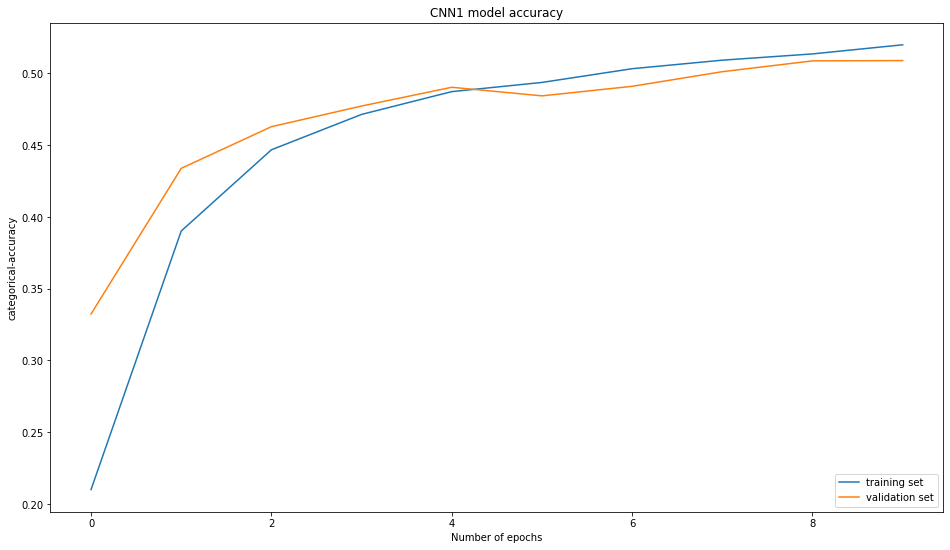

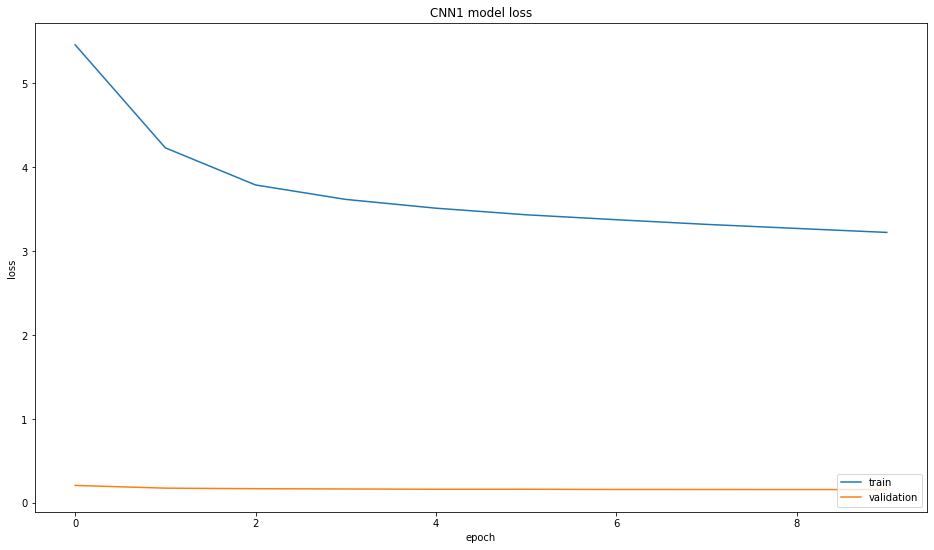

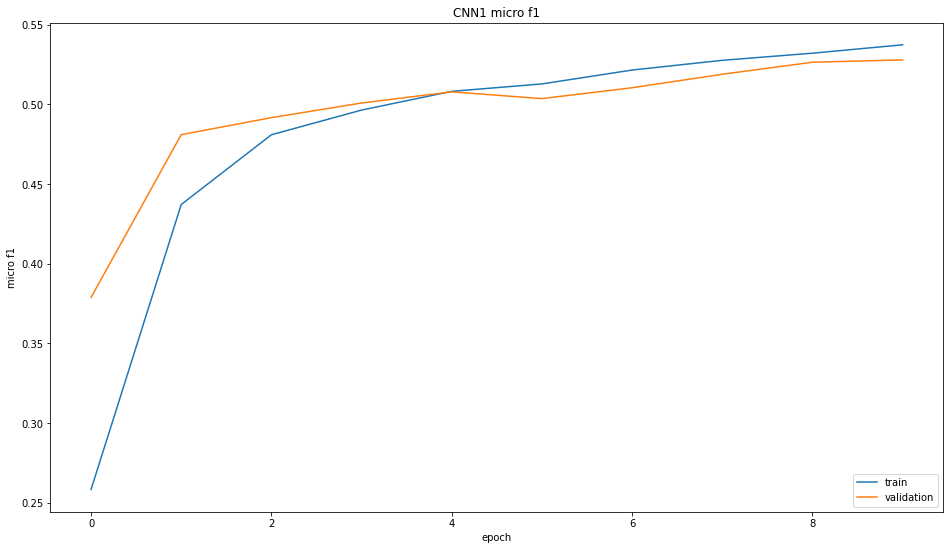

In [82]:
#plotting the accuracy, loss and micro-F1 score
plt.plot(history1.history['categorical-accuracy'])
plt.plot(history1.history['val_categorical-accuracy'])
plt.title('CNN1 model accuracy')
plt.ylabel('categorical-accuracy')
plt.xlabel('Number of epochs')
plt.legend(['training set', 'validation set'], loc='lower right')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('CNN1 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history1.history['micro-f1'])
plt.plot(history1.history['val_micro-f1'])
plt.title('CNN1 micro f1')
plt.ylabel('micro f1')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [67]:
confusion_matrix1 = sklearn.metrics.multilabel_confusion_matrix(y_test, model.predict(x_test).round(), sample_weight=None)

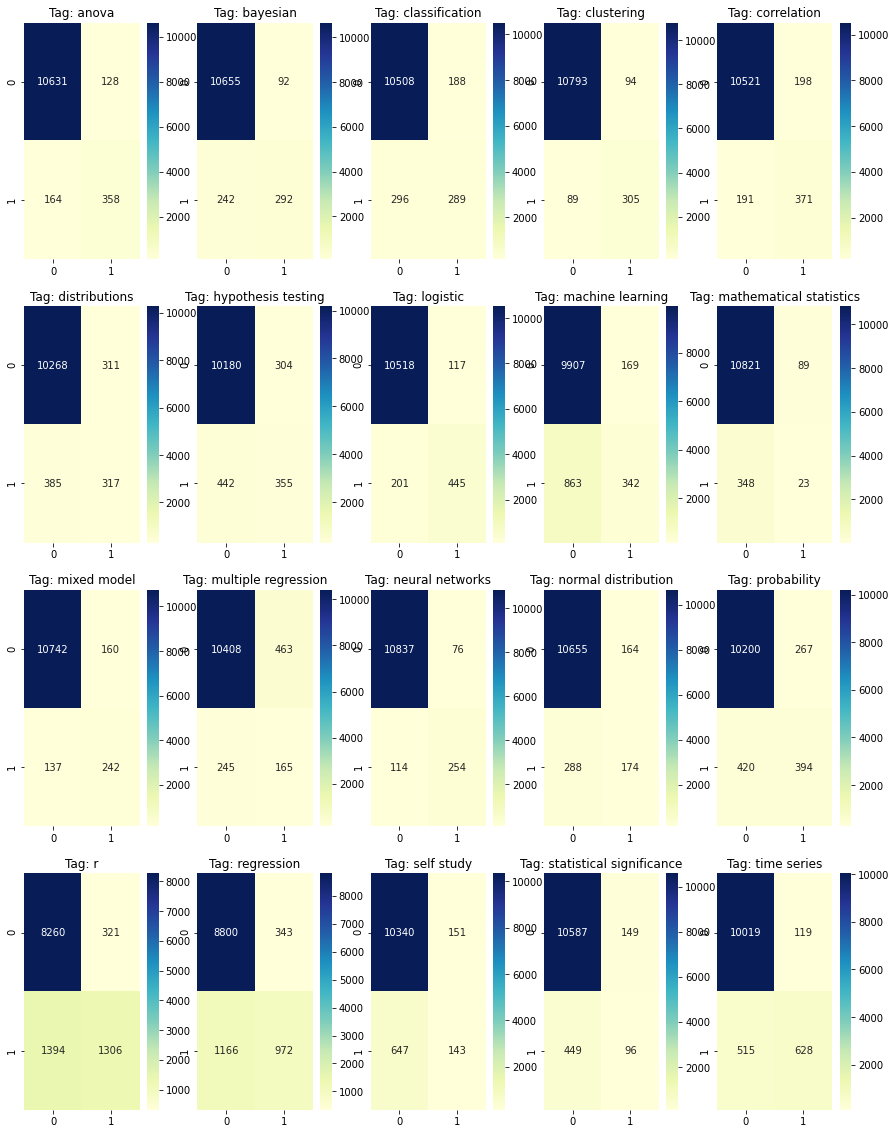

In [68]:
#code referenced from Team mate - Prabha Krishnamooorthy
import seaborn as sns
import math 

#plotting the confusion matrix for each labels
labelnames = list(mlb.classes_)

fig = plt.figure(figsize = (15,20))
cols=5
rows = math.ceil(len(labelnames)/cols)

for i, col in enumerate(labelnames):
  ax = fig.add_subplot(rows,cols, i +1)
  sns.heatmap(confusion_matrix1[i], annot = True, fmt = 'd', cmap = 'YlGnBu')
  ax.set(title = 'Tag: {0}'.format(col))

plt.show()

**CNN1 Model summary:** 

|Model |Hamming Loss|micro-F1|macro-F1 |Binary Accuracy|Categorical Accuracy  |
|------|------------|--------|---------|---------------|----------------------|
|CNN 1 | 0.0553     | 0.5236 |  0.5106 |    0.9446     |       0.5132         |


Our first model has performed really well on testing data for the multilabel classification task at hand, based on the metrics seen above. Let's try tuning the parameters and to see if the performance can be improved.

# CNN2 - Experiment 2
For our second experiment we try and improve the CNN1 model's performance by changing the hyperparameters. The following chnages are made compared to the first model:
1. Batch size changed from 32 to 64
2. Trainable Embeddings are used.

In [69]:
model2= Sequential()
model2.add(Embedding(max_words, 50, trainable = True, input_length=maxlen))
model2.add(Dropout(0.1))
model2.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model2.add(GlobalMaxPool1D())
model2.add(Dense(num_classes))
model2.add(Activation('sigmoid'))

model2.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001),
              loss='binary_crossentropy', 
              metrics=[tfa.metrics.F1Score(num_classes=num_classes, average = 'micro', name = 'micro-f1'),
                       tfa.metrics.F1Score(num_classes=num_classes, average = 'macro', name = 'macro-f1'),
                       keras.metrics.BinaryAccuracy(name='binary-accuracy'),
                       keras.metrics.CategoricalAccuracy(name = 'categorical-accuracy')])

model2.summary()

callbacks = [ReduceLROnPlateau(), 
             EarlyStopping(patience=4), 
             ModelCheckpoint(filepath='model2-NLPCW.h5', save_best_only=True)
]

history2 = model2.fit(x_train, y_train,
                    epochs=10,
                    class_weight=class_weight,
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=callbacks)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 50)           10000000  
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 50)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 198, 200)          30200     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                4020      
_________________________________________________________________
activation_2 (Activation)    (None, 20)                0         
Total params: 10,034,220
Trainable params: 10,034,220
Non-trainable params: 0
__________________________________________

In [76]:
CNN2 = keras.models.load_model('model2-NLPCW.h5') 

In [77]:
metrics = CNN2.evaluate(x_test, y_test)
print("The metrics for CNN model 2 on Testing data:")
print("{}: {}".format(model2.metrics_names[0], metrics[0]))
print("{}: {}".format(model2.metrics_names[1], metrics[1]))
print("{}: {}".format(model2.metrics_names[2], metrics[2]))
print("{}: {}".format(model2.metrics_names[3], metrics[3]))
print("{}: {}".format(model2.metrics_names[4], metrics[4]))

353/353 [==============================] - 1s 3ms/step - loss: 0.1303 - micro-f1: 0.5853 - macro-f1: 0.5761 - binary-accuracy: 0.9520 - categorical-accuracy: 0.5816
The metrics for CNN model 2 on Testing data:
loss: 0.13027051091194153
micro-f1: 0.5852713584899902
macro-f1: 0.5760819911956787
binary-accuracy: 0.9519503116607666
categorical-accuracy: 0.5815973877906799


In [86]:
#printing the Hamming loss for model 2
print('Hamming loss for CNN2: {0}'.format(sklearn.metrics.hamming_loss(y_test,  model2.predict(x_test).round(), sample_weight=None)))

Hamming loss for CNN2: 0.052841060189699494


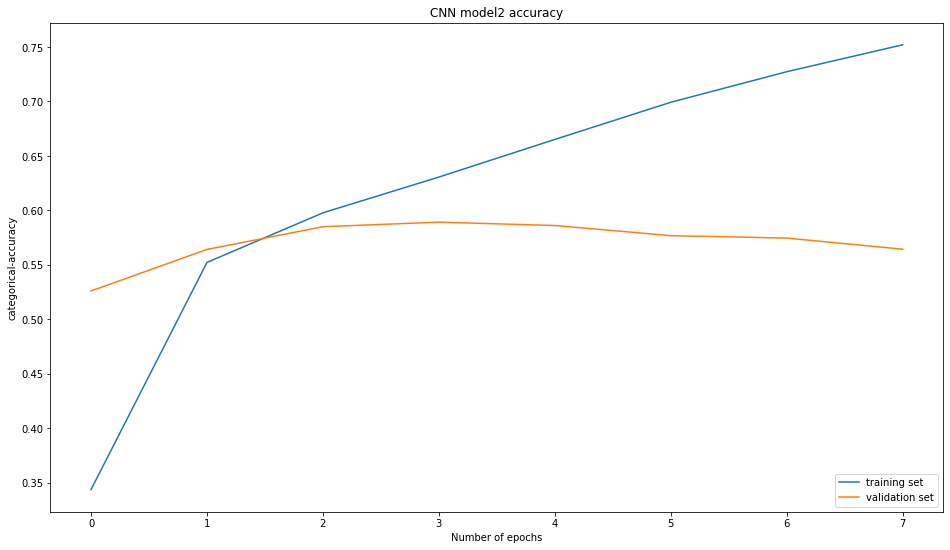

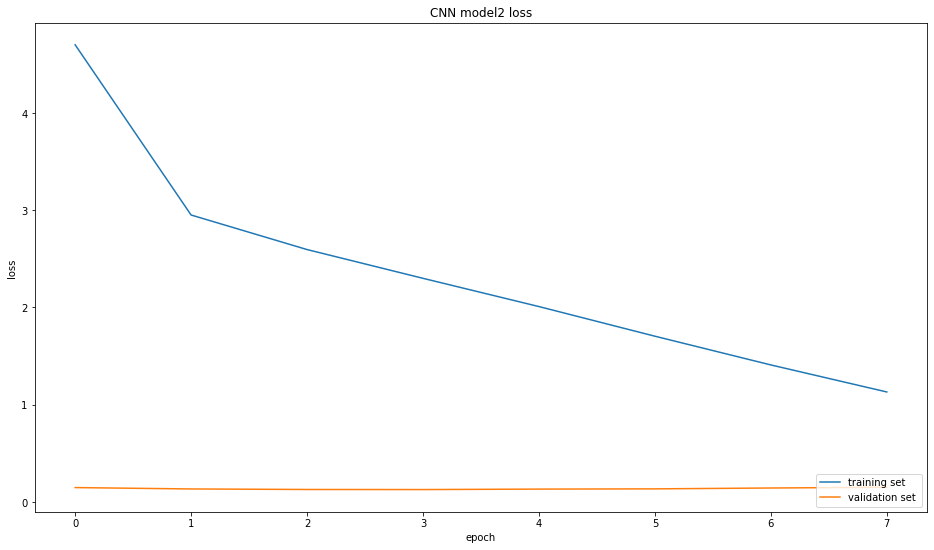

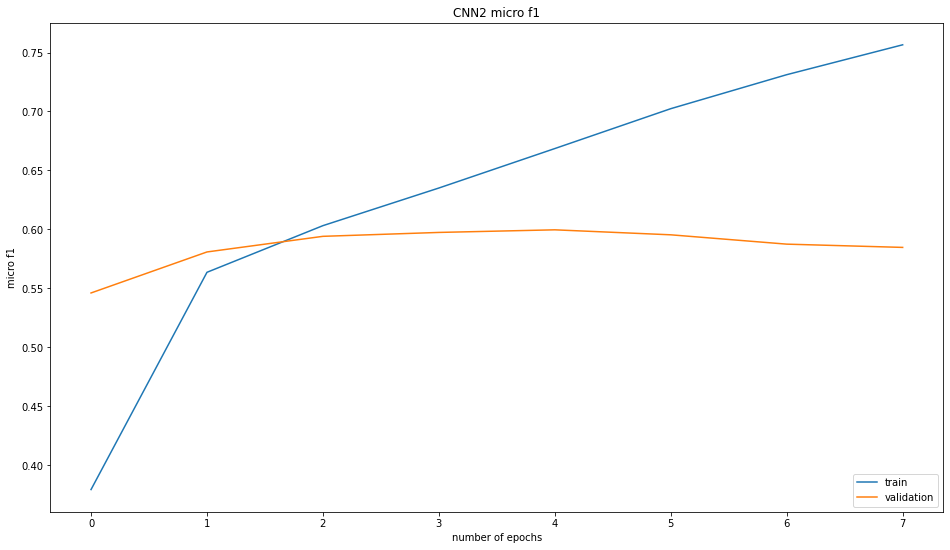

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [84]:
plt.plot(history2.history['categorical-accuracy'])
plt.plot(history2.history['val_categorical-accuracy'])
plt.title('CNN model2 accuracy')
plt.ylabel('categorical-accuracy')
plt.xlabel('Number of epochs')
plt.legend(['training set', 'validation set'], loc='lower right')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('CNN model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set '], loc='lower right')
plt.show()

plt.plot(history2.history['micro-f1'])
plt.plot(history2.history['val_micro-f1'])
plt.title('CNN2 micro f1')
plt.ylabel('micro f1')
plt.xlabel('number of epochs')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [74]:
confusion_matrix2 = sklearn.metrics.multilabel_confusion_matrix(y_test, model2.predict(x_test).round())

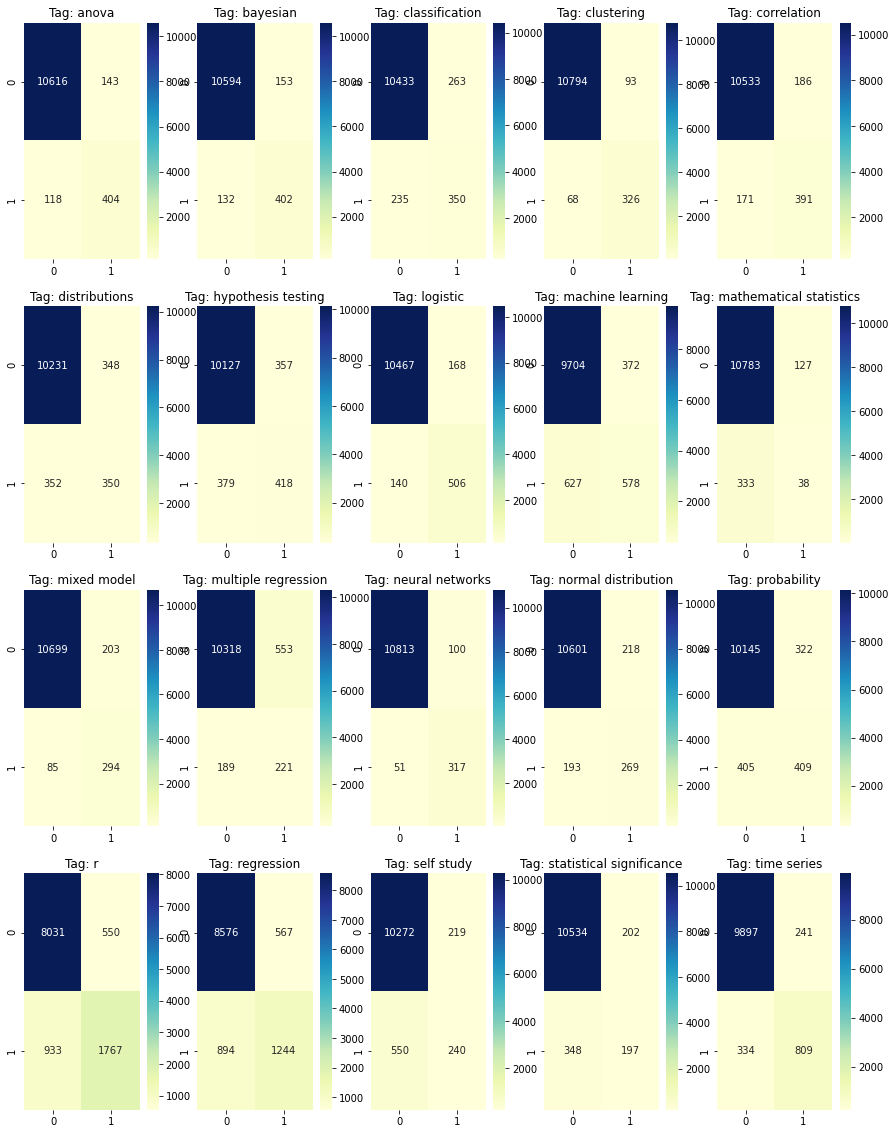

In [79]:
#plotting the confusion matrix for each labels
labelnames = list(mlb.classes_)

fig = plt.figure(figsize = (15,20))
cols=5
rows = math.ceil(len(labelnames)/cols)

for i, col in enumerate(labelnames):
  ax = fig.add_subplot(rows,cols, i +1)
  sns.heatmap(confusion_matrix2[i], annot = True, fmt = 'd', cmap = 'YlGnBu')
  ax.set(title = 'Tag: {0}'.format(col))

plt.show()

# Model comparison:

|Model |Hamming Loss|micro-F1|macro-F1 |Binary Accuracy|Categorical Accuracy  |
|------|------------|--------|---------|---------------|----------------------|
|CNN 1 | 0.0553     | 0.5236 |  0.5106 |    0.9446     |       0.5132         |
|CNN 2 | 0.0528     | 0.5852 |  0.5760 |    0.9519     |       0.5815         |

Setting the embeddings to trainable and increasing the batch size to 64 has significantly increased the performace of our model with lower Hamming loss, higher F1 scores and categorical accuracy. However, as seen from the graphs the model starts to overfit the data as the number of epochs increases this could be because we set the embeddings as trainable.

# Further steps:
In the next notebook, we experiment with Word2Vec embeddings of 300 dimensions along with different hyper-parameters, to see how it affects our model's performance. 

